In [8]:
!pip3 install timm wholeslidedata

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 388.5 kB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.2 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for wholeslidedata: filename=wholeslidedata-0.0.15-py3-none-any.whl size=82664 sha256=719f4599d4b1d142f30d8f4ccda7a82563c370be9fa00f90ed7d8d3838493983
  Stored in directory: /home/user/.cache/pip/wheels/1c/9f/79/0dd6b7fd6fcf33dc4a4d57958aa68630daeb84bc6f90970327
  Created wheel for concurrentbuffer: filename=concurrentbuffer-0.0.7-py3-none-any.whl size=10172 sha256=8d72a1221090c935d64e2e2946787676b57b1938153ea2bcfa56c69a1a7e5bfa
  Stored in directory: /home/user/.cache/pip/wheels/f3/d5/22/d8cd1a5c1b8b31f5144a5

In [1]:
import os

os.environ["nnUNet_raw_data_base"] = "/data/pathology/projects/pathology-endoaid/phase 3 - nnUNet/nnUNet_raw_data_base_7cl_revised/"
os.environ["nnUNet_preprocessed"] = "/data/pathology/projects/pathology-endoaid/phase 3 - nnUNet/nnUNet_raw_data_base_7cl_revised/nnUNet_preprocessed"
os.environ["RESULTS_FOLDER"] = "/data/pathology/projects/pathology-endoaid/phase 3 - nnUNet/nnUNet_raw_data_base_7cl_revised/results"

In [2]:
import sys

sys.path.append("/data/pathology/projects/pathology-endoaid/phase 3 - nnUNet")

from nifti_utils import *

In [3]:
from nnunet.training.network_training.diag.nnUNetTrainerV2MultiScale import nnUNetTrainerV2MultiScale



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



In [4]:
plans_file = "/data/pathology/projects/pathology-endoaid/phase 3 - nnUNet/nnUNet_raw_data_base_7cl_revised/nnUNet_preprocessed/Task507_endometrium_carcinoma_segmentation/nnUNetPlansv2.1_MultiScale_plans_2D.pkl"
fold = 1
trainer = nnUNetTrainerV2MultiScale(
    plans_file,
    fold,
    output_folder='/data/pathology/projects/pathology-endoaid/phase 3 - nnUNet/nnUNet_raw_data_base_7cl_revised/results/nnUNet/2d/Task507_endometrium_carcinoma_segmentation/nnUNetTrainerV2MultiScale__nnUNetPlansv2.1_MultiScale',
    dataset_directory='/data/pathology/projects/pathology-endoaid/phase 3 - nnUNet/nnUNet_raw_data_base_7cl_revised/nnUNet_preprocessed/Task507_endometrium_carcinoma_segmentation',
    stage=0,
    deterministic=False,
    fp16=True,
    data_origin='/data/pathology/archives/endometrium/endoaid/wsis/dense annotations/tif/*',
    timm_encoder_kwargs={'model_name': 'resnet18'}
)

In [5]:
trainer.initialize()

loading dataset
loading all case properties
unpacking dataset
done
using pin_memory on device 0
using pin_memory on device 0


In [6]:
data_dict = next(trainer.tr_gen)  # Don't use zero-padding, sample bigger and then crop
main = data_dict['data']
target = data_dict['target']

In [7]:
from glob import glob
from wholeslidedata.accessories.asap.parser import AsapAnnotationParser
from wholeslidedata.annotation.wholeslideannotation import WholeSlideAnnotation
from wholeslidedata.image.wholeslideimage import WholeSlideImage
import numpy as np

In [8]:
def sample_context(self, properties, keys):
    parser = AsapAnnotationParser(labels={'none': 0}, sample_label_names=['none'])
    context = np.zeros((len(properties), self.plans['num_modalities'], *self.patch_size))
    for indx, props in enumerate(properties):
        anno_number = int(keys[indx].split("_")[-1].strip("ROI"))
        wsa = WholeSlideAnnotation(glob(f"{self.data_origin}/{'_'.join(keys[indx].split('_')[:5])}.xml")[0],
                                   parser=parser)
        wsi = WholeSlideImage(glob(f"{self.data_origin}/{'_'.join(keys[indx].split('_')[:5])}.tif")[0],
                              backend='asap')
        anno = wsa.sampling_annotations[anno_number]
        x, y = anno.center
        x += props['offset_x']
        y += props['offset_y']
        print(props['offset_x'], props['offset_y'])
        context[indx] = wsi.get_patch(
            x,
            y,
            *self.patch_size,
            spacing=0.5
        ).transpose(2, 0, 1)
    return context

trainer.sample_context = sample_context

In [9]:
context = trainer.sample_context(trainer, data_dict['properties'], data_dict['keys'])

89 -101
-277 378


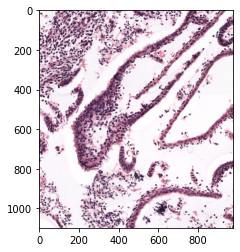

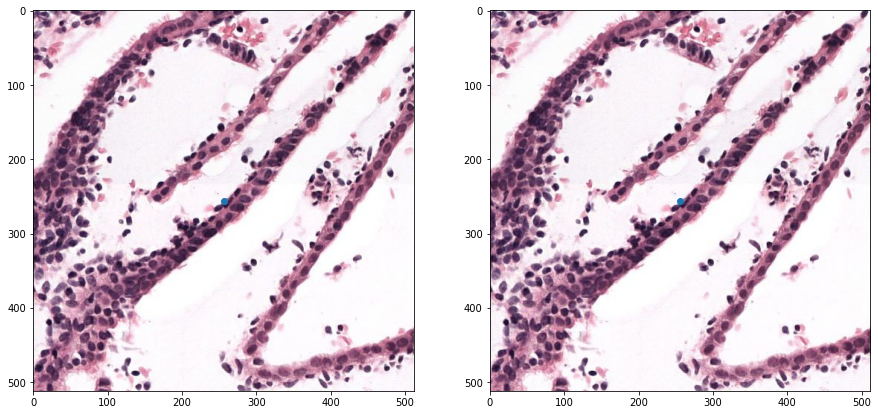

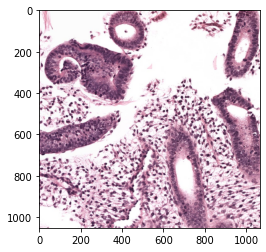

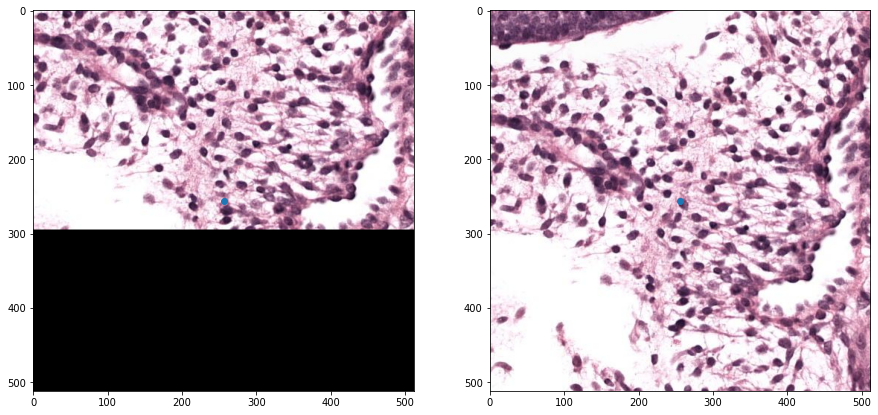

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import block_reduce

plt.imshow(convert_nifti_to_tif(data_dict['properties'][0]['list_of_data_files']))
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
main_plottable = main[0].numpy().astype(int).transpose(1, 2, 0)
axs[0].imshow(main_plottable)
axs[0].scatter(512//2, 512//2)
context_plottable = context[0].astype(int).transpose(1, 2, 0)
axs[1].imshow(context_plottable)
axs[1].scatter(512//2, 512//2)
plt.show()


plt.imshow(convert_nifti_to_tif(data_dict['properties'][1]['list_of_data_files']))
plt.show()
fig, axs = plt.subplots(1, 2, figsize=(15, 15))

main_plottable = main[1].numpy().astype(int).transpose(1, 2, 0)
axs[0].imshow(main_plottable)
axs[0].scatter(512//2, 512//2)
context_plottable = context[1].astype(int).transpose(1, 2, 0)
axs[1].imshow(context_plottable)
axs[1].scatter(512//2, 512//2)
plt.show()